# Creating a hyperdictionary

I was considering that the basic way to solve the letter prediction problem given no constraints, would be to just have a dictionary of words, and then be able to reference that dictionary. I am attempting to store a dictionary into a hypervector and create a hyperdictionary.

The hypervectors are very similar to hashes, and so each word or subword has no relationship to the hash. So in order to store a dictionary in the hyper vector, you need to store the word and all of the substrings. 

Essentially, I am encoding an algorithm in the hypervector that does a tree search through a dictionary. I want to start typing in letters and then have the hyperdictionary list the possible next letters given the words that are stored. This means I want to store not only everyword, but the entire tree of substrings that make up the word. 


In [1]:

import random_idx
import utils
import pickle

from pylab import *

%matplotlib inline


height has been deprecated.

2016-01-31 14:12


## Building the hyper dictionary

So, I have gone to the internet and just found a text file that contains a list of common english words. My goal is to put this dictionary into a hyper vector and then see if I can use a standard word-based algorithm to predict the next letter.

In [2]:
fdict = open("2of12id.txt")
word_list = []

In [3]:
for line in fdict:
    words = line.split()
    
    # take out the noun/verb/adjective
    words.pop(1)
    
    for word in words:
        if word.find('{') > 0:
            continue
            
        w = word.strip('()~-|{}!@/')
        
        if len(w) == 0:
            continue
        
        print w
        word_list.append(w)

aardvark
aardvarks
aback
abacus
abacuses
abaci
abaft
abalone
abalones
abandon
abandoned
abandoning
abandons
abandonment
abandonments
abase
abased
abasing
abases
abasement
abasements
abash
abashed
abashing
abashes
abashedly
abashment
abashments
abate
abated
abating
abates
abatement
abatements
abattoir
abattoirs
abbe
abbes
abbess
abbesses
abbey
abbeys
abbot
abbots
abbreviate
abbreviated
abbreviating
abbreviates
abbreviation
abbreviations
abdicate
abdicated
abdicating
abdicates
abdication
abdications
abdomen
abdomens
abdominal
abdominal
abdominals
abduct
abducted
abducting
abducts
abduction
abductions
abductor
abductors
abeam
abed
aberrant
aberrant
aberrants
aberration
aberrations
aberrational
abet
abetted
abetting
abets
abetter
abetters
abettor
abettors
abeyance
abeyances
abhor
abhorred
abhorring
abhors
abhorrence
abhorrences
abhorrent
abhorrently
abidance
abidances
abide
abode
abided
abiding
abides
abidingly
ability
abilities
abject
abjection
abjections
abjectly
abjectness
abjectnesses


In [4]:
print len(word_list)

100060


So, we have a dictionary of over 100,000 words now. I am going to go through each word, substring by substring, and add each of the substrings to the hypervector. This means that there will be far more than 100k elements that need to be stored in the hypervector, because I am essentially trying to store the entire tree. Since there are so many words, I am going to start using an even larger hyper-vector. There will be issues with how much information we can store in the hypervectors, and there is already some literature on this. 

I really want the hyper vector to just work like a word dictionary. I am only going to add a substring if it is not already present. 

In [5]:
# We'll have N_pos+N_neg length hypervector
N_pos = 100000
N_neg = 100000
N = N_pos + N_neg

letter_vectors = np.zeros((len(random_idx.alphabet), N))

# This way ensures each vector is the same number of +1 and -1
for i in range(len(random_idx.alphabet)):
    letter_vectors[i,:] = np.random.permutation(np.hstack((np.ones(N_pos), -np.ones(N_neg))))
    
print letter_vectors
print letter_vectors.shape

[[ 1. -1.  1. ...,  1. -1. -1.]
 [-1. -1. -1. ..., -1.  1. -1.]
 [ 1. -1.  1. ..., -1.  1. -1.]
 ..., 
 [-1. -1. -1. ..., -1.  1.  1.]
 [ 1. -1.  1. ...,  1. -1. -1.]
 [-1. -1.  1. ...,  1.  1.  1.]]
(27, 200000)


In [6]:
hyperdictionary = np.zeros(N)
count = 0
vals = []
subwords = []

for word in word_list[0::100]:
#for word in ['accelerate','aardvark', 'accordion', 'accordionists',  'apple', 'betazoid', 'betakeratine']:
#for word in ['a', 'b', 'c', 'd','e', 'f']:
    print ""
    print word,
    subword = ''
    subvec = np.ones(N)
    for i,letter in enumerate(word):
        letter_idx = random_idx.alphabet.find(letter)
        subvec = np.roll(subvec, 1) * letter_vectors[letter_idx,:]
        subword += letter
        
        # check to see if the subvec is already present in the hyperdictionary
        val = np.dot(subvec.T, hyperdictionary) / N
        vals.append(val)
        subwords.append(subword)
        
        # If the substring is not present, then val should be near 0
        if val < 0.3:
            # then add the substring
            hyperdictionary += subvec
            count += 1
            print subword, 
        


aardvark a aa aar aard aardv aardva aardvar aardvark 
abiding ab abi abid abidi abidin abiding 
abrade abr abra abrad abrade 
absorbed abs abso absor absorb absorbe absorbed 
academy ac aca acad acade academ academy 
accompanists acc acco accom accomp accompa accompan accompani accompanis accompanist accompanists 
accusative accu accus accusa accusat accusati accusativ accusative 
acoustics aco acou acous acoust acousti acoustic acoustics 
activeness act acti activ active activen activene activenes activeness 
addicted ad add addi addic addict addicte addicted 
adjudication adj adju adjud adjudi adjudic adjudica adjudicat adjudicati adjudicatio adjudication 
adoptable ado adop adopt adopta adoptab adoptabl adoptable 
advantageous adv adva advan advant advanta advantag advantage advantageo advantageou advantageous 
adzing adz adzi adzin adzing 
affinities af aff affi affin affini affinit affiniti affinitie affinities 
aftershocks aft afte after afters aftersh aftersho aftershoc aftersh

In [7]:
hyperdictionary.shape

(200000,)

In [8]:
np.savez('hyperdictionary_s100_160131.npz', hyperdictionary=hyperdictionary, letter_vectors=letter_vectors)

## Exploring the hyperdictionary

Ok, so I have taken out 99% of the words, because the full word list is just too much for the hyperdictionary to hold.

So, we will first just look at the small version.

In [9]:
h = np.load('hyperdictionary_s100_160131.npz')

In [10]:
hyperdictionary = h['hyperdictionary']
letter_vectors = h['letter_vectors']

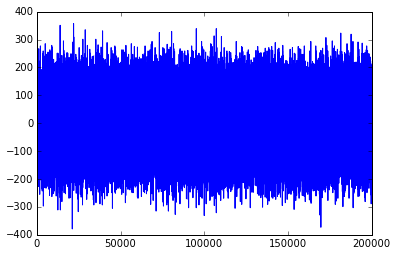

In [11]:
plot(hyperdictionary);

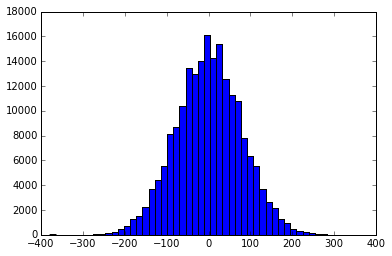

In [12]:
hist(hyperdictionary, 50);

So, for every word we are storing the whole word tree if it is not already present in the hyperdictionary. So here are a few words that start with 'bu' that we written, followed by each substring from the word that was added to the dictionary:

bubbly bu bub bubb bubbl bubbly  
buff buf buff  
bulking bul bulk bulki bulkin bulking  
bulwark bulw bulwa bulwar bulwark  
bunked bun bunk bunke bunked  
burglarproofed bur burg burgl burgla burglar burglarp burglarpr burglarpro burglarproo burglarproof burglarproofe burglarproofed   
burst burs burst  
busier bus busi busie busier  

Here is a widget that will display the histogram of the next letter for any string you type. However, you probably cannot run it on the notebook viewer:

array([ 0.88962, -0.20464, -0.20334,  0.07392,  0.18352,  0.00216,
       -0.04544,  0.01798, -0.11756,  0.17718, -0.1333 ,  0.10738,
       -0.15138, -0.17846,  0.0256 , -0.1377 ,  0.01666,  0.10548,
       -0.05126, -0.14846,  0.2593 ,  0.14356, -0.12914, -0.0992 ,
       -0.17798,  0.10456,  0.19072])

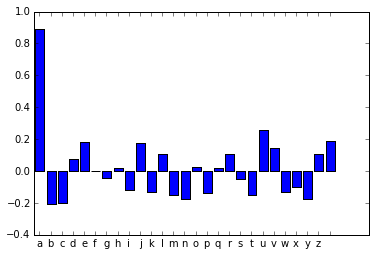

In [13]:
from ipywidgets import widgets
from IPython.display import display
from IPython.html.widgets import *

figure(figsize=(8,5))

def next_letter_hist(instring):
    #instring = sender.value
    subvec = np.ones(N)
    for letter in instring:
        lidx = random_idx.alphabet.find(letter)
        subvec = np.roll(subvec, 1) * letter_vectors[lidx,:]
        
    subvec = np.roll(subvec, 1)
    val = np.dot(letter_vectors/N, subvec*hyperdictionary)
    bar(arange(len(val))+0.15, val)   
    ax=gca()
    ax.set_xticks(arange(len(random_idx.alphabet))+0.5)
    th = ax.set_xticklabels(list(random_idx.alphabet))
    return val

#input_text = widgets.Text()
#input_text.on_submit(next_letter_hist)
#display(input_text)

interact(next_letter_hist, instring="")


In [14]:
def get_next_letters(v, thresh=0.5):
    next_letters = ''
    for idx in np.nonzero(v>thresh)[0]:
        next_letters += random_idx.alphabet[idx]
    return next_letters

First, here is just all the letters, basically the dictionary has no 'x' and ' ' starting words:

abcdefghijklmnopqrstuvwyz


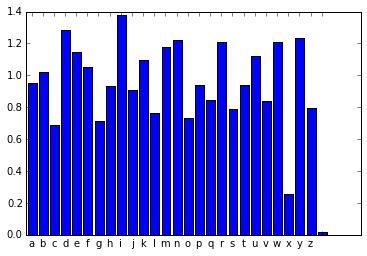

In [15]:
v = next_letter_hist('')
print get_next_letters(v)

Now, when you type in b, you can see the distributrion for the next letters:

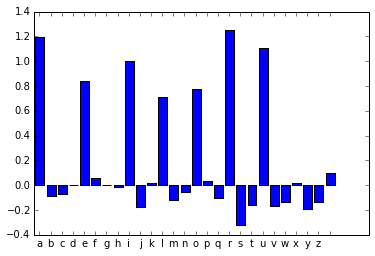

In [16]:
v = next_letter_hist('b')

bflnrs


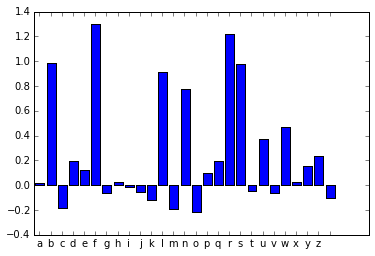

In [17]:
v = next_letter_hist('bu')
print get_next_letters(v)

because we have: 'bubbly', 'buff', 'bulking', 'bulwark', 'burgarlarproofed', 'burst', 'busier'

'bubbly' is the only word that starts with bub. So the dictionary says 'b' is next.

b


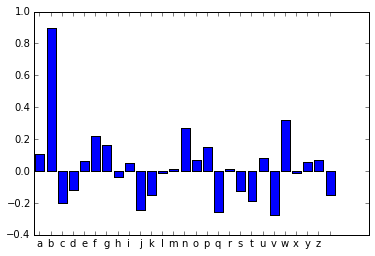

In [18]:
v = next_letter_hist('bub')
print get_next_letters(v)

There is 'bulking' and 'bulwark', so 'bul' says 'k' or 'w'

kw


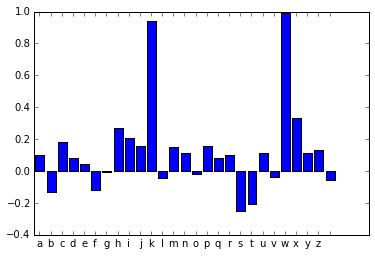

In [19]:
v = next_letter_hist('bul')
print get_next_letters(v)

And with a word that was not stored in the dictionary, we get small values:

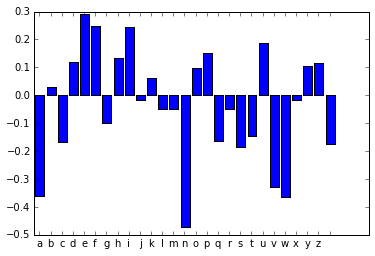

In [20]:
v = next_letter_hist('bull')
print get_next_letters(v)